# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os, time
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch, cv2
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist
from layers import *

## Setting up network and loading weights

In [2]:
#model_name = "D:\\desktop_D\\NN\\monodepth2+fast-SCNN_test\\Monodepth2\\model\\"
#model_name = "D:\\MyNet\\monodepth2\\models\\mine_log_data\\ZED_1211_seperate_mono+stereo_640x352\\weights_{}".format(19)
model_name = "D:\\desktop_D\\NN\\monodepth2+fast-SCNN_test\\Monodepth2\\model\\"

encoder_path = os.path.join(model_name, "encoder.pth")
depth_decoder_path = os.path.join(model_name, "depth.pth")

encoder = networks.ResnetEncoder(18, False).cuda()
print("encoder.num_ch_enc:", encoder.num_ch_enc)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

depth_decoder.load_state_dict(torch.load(depth_decoder_path))

encoder.eval()
depth_decoder.eval()

pose_encoder_path = os.path.join(model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join(model_name, "pose.pth")

pose_encoder = networks.ResnetEncoder(18, False, 2).cuda()
pose_encoder.load_state_dict(torch.load(pose_encoder_path))

pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2).cuda()
pose_decoder.load_state_dict(torch.load(pose_decoder_path))

pose_encoder.eval()
pose_decoder.eval();

encoder.num_ch_enc: [ 64  64 128 256 512]


## Loading the test image and preprocessing

In [3]:
image_path_0 = "D:\\my_datasets\\depth_estimation\\ZED_data\\ZED_output\\3\\image_02\\data\\image307.jpg"
image_path_1 = "D:\\my_datasets\\depth_estimation\\ZED_data\\ZED_output\\3\\image_02\\data\\image308.jpg"
image_path_2 = "D:\\my_datasets\\depth_estimation\\ZED_data\\ZED_output\\3\\image_02\\data\\image309.jpg"
image_path_s = "D:\\my_datasets\\depth_estimation\\ZED_data\\ZED_output\\3\\image_03\\data\\image308.jpg"
#image_path_1 = "D:\\my_datasets\\depth_estimation\\ZED_data\\ZED_output\\9\\image_02\\data\\image92.jpg"
#image_path_2 = "D:\\my_datasets\\depth_estimation\\ZED_data\\ZED_output\\9\\image_02\\data\\image93.jpg"

input_image_0 = pil.open(image_path_0).convert('RGB')
input_image_1 = pil.open(image_path_1).convert('RGB')
input_image_2 = pil.open(image_path_2).convert('RGB')
input_image_s = pil.open(image_path_s).convert('RGB')
original_width, original_height = input_image_0.size
print("original_height, original_width:", original_height, original_width)
feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
print("feed_height, feed_width:", feed_height, feed_width)
input_image_0_resized = input_image_0.resize((feed_width, feed_height), pil.LANCZOS)
input_image_1_resized = input_image_1.resize((feed_width, feed_height), pil.LANCZOS)
input_image_2_resized = input_image_2.resize((feed_width, feed_height), pil.LANCZOS)
input_image_s_resized = input_image_s.resize((feed_width, feed_height), pil.LANCZOS)

input_image_0_pytorch = transforms.ToTensor()(input_image_0_resized).unsqueeze(0).cuda()
input_image_1_pytorch = transforms.ToTensor()(input_image_1_resized).unsqueeze(0).cuda()
input_image_2_pytorch = transforms.ToTensor()(input_image_2_resized).unsqueeze(0).cuda()
input_image_s_pytorch = transforms.ToTensor()(input_image_s_resized).unsqueeze(0).cuda()

original_height, original_width: 360 640
feed_height, feed_width: 352 640


## Prediction using the PyTorch model

In [4]:
start = time.time()
with torch.no_grad():
    features = encoder(torch.cat([input_image_0_pytorch, input_image_1_pytorch, input_image_2_pytorch, input_image_s_pytorch], 0))
    outputs = depth_decoder(features)
    disp_0 = outputs[("disp", 0)][0]
    disp_1 = outputs[("disp", 0)][1]
    disp_2 = outputs[("disp", 0)][2]
    disp_s = outputs[("disp", 0)][3]
    
    features_pose_0_to_1 = [pose_encoder(torch.cat([input_image_0_pytorch, input_image_1_pytorch], 1))]
    axisangle_0_to_1, translation_0_to_1 = pose_decoder(features_pose_0_to_1)
    
    features_pose_2_to_1 = [pose_encoder(torch.cat([input_image_2_pytorch, input_image_1_pytorch], 1))]
    axisangle_2_to_1, translation_2_to_1 = pose_decoder(features_pose_2_to_1)
    
    features_pose_s_to_1 = [pose_encoder(torch.cat([input_image_s_pytorch, input_image_1_pytorch], 1))]
    axisangle_s_to_1, translation_s_to_1 = pose_decoder(features_pose_s_to_1)
    
    torch.cuda.synchronize()
print("FPS:", 1 / (time.time() - start))

FPS: 1.0566187175231065


## Plotting

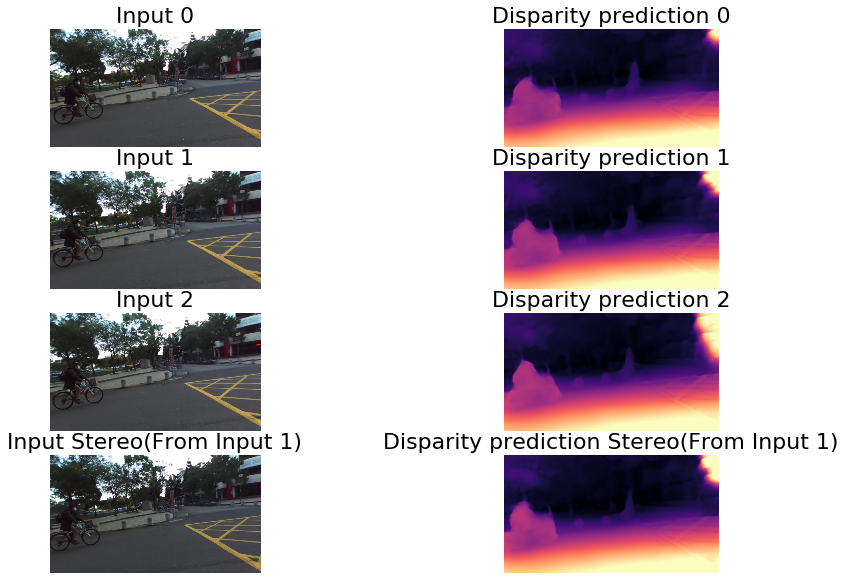

In [5]:
#disp_resized = torch.nn.functional.interpolate(disp,
#    (original_height, original_width), mode="bilinear", align_corners=False)

disp_0_np = disp_0.squeeze().cpu().numpy()
disp_1_np = disp_1.squeeze().cpu().numpy()
disp_2_np = disp_2.squeeze().cpu().numpy()
disp_s_np = disp_s.squeeze().cpu().numpy()
vmax = np.percentile(disp_0_np, 95)

plt.figure(figsize=(15, 10))
plt.subplot(421)
plt.imshow(input_image_0)
plt.title("Input 0", fontsize=22)
plt.axis('off')
#plt.show()

plt.subplot(422)
plt.imshow(disp_0_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction 0", fontsize=22)
plt.axis('off')
#plt.show()

plt.subplot(423)
plt.imshow(input_image_1)
plt.title("Input 1", fontsize=22)
plt.axis('off')
#plt.show()

plt.subplot(424)
plt.imshow(disp_1_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction 1", fontsize=22)
plt.axis('off')
#plt.show()

plt.subplot(425)
plt.imshow(input_image_2)
plt.title("Input 2", fontsize=22)
plt.axis('off')
#plt.show()

plt.subplot(426)
plt.imshow(disp_2_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction 2", fontsize=22)
plt.axis('off')
#plt.show()

plt.subplot(427)
plt.imshow(input_image_s)
plt.title("Input Stereo(From Input 1)", fontsize=22)
plt.axis('off')
#plt.show()

plt.subplot(428)
plt.imshow(disp_s_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction Stereo(From Input 1)", fontsize=22)
plt.axis('off')
plt.show();

In [6]:
K = np.array([[700,    0, 640, 0],
              [   0, 700, 360, 0],
              [   0,   0,   1, 0],
              [   0,   0,   0, 1]], dtype=np.float32)
K[0,:] *= feed_width/original_width
K[1,:] *= feed_height/original_height
K_inverse = np.linalg.inv(K)

In [7]:
back_project_depth = BackprojectDepth(1, feed_height, feed_width).cuda()
project_3d = Project3D(1, feed_height, feed_width).cuda()

disp_0_,depth_0 = disp_to_depth(disp_0, 0.1, 100)
disp_1_,depth_1 = disp_to_depth(disp_1, 0.1, 100)
disp_2_,depth_2 = disp_to_depth(disp_2, 0.1, 100)
disp_s_,depth_s = disp_to_depth(disp_s, 0.1, 100)

start_ = time.time()
cam_points = back_project_depth(depth_1, torch.FloatTensor(K_inverse[np.newaxis, :]).cuda())
T = transformation_from_parameters(axisangle_0_to_1[:, 0], translation_0_to_1[:, 0], True)
pix_coords = project_3d(cam_points, torch.FloatTensor(K[np.newaxis, :]).cuda(), T)

with torch.no_grad():
    image_warped_0_to_1 = F.grid_sample(input_image_0_pytorch, pix_coords, padding_mode="border")

T = transformation_from_parameters(axisangle_2_to_1[:, 0], translation_2_to_1[:, 0], True)
pix_coords = project_3d(cam_points, torch.FloatTensor(K[np.newaxis, :]).cuda(), T)

with torch.no_grad():
    image_warped_2_to_1 = F.grid_sample(input_image_2_pytorch, pix_coords, padding_mode="border")

T = transformation_from_parameters(axisangle_s_to_1[:, 0], translation_s_to_1[:, 0], True)
pix_coords = project_3d(cam_points, torch.FloatTensor(K[np.newaxis, :]).cuda(), T)

with torch.no_grad():
    image_warped_s_to_1 = F.grid_sample(input_image_s_pytorch, pix_coords, padding_mode="border")

torch.cuda.synchronize()
print("FPS:", 1 / (time.time() - start_))

FPS: 3.908659186640325


In [8]:
a = cam_points.cpu()
a.detach().numpy()

array([[[-5.9818592e+00, -5.9770246e+00, -5.9693007e+00, ...,
         -5.4632556e-03, -3.6355630e-03, -1.8161153e-03],
        [-3.3647954e+00, -3.3673375e+00, -3.3682573e+00, ...,
         -1.8624442e-03, -1.8590784e-03, -1.8573357e-03],
        [ 6.5426583e+00,  6.5476012e+00,  6.5493894e+00, ...,
          1.2747482e+00,  1.2724445e+00,  1.2712517e+00],
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00]]], dtype=float32)

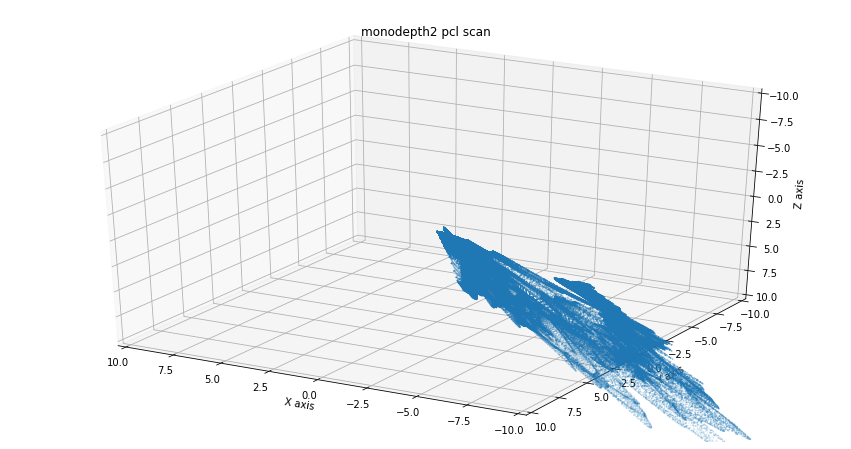

In [9]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [10, -10], # X axis range
    [10, -10], # Y axis range
    [10, -10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']
point_size = 0.01 * (1. / 0.2)
def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    a = cam_points.cpu()
    x = a.detach().numpy()[0][0]
    y = a.detach().numpy()[0][1]
    z = a.detach().numpy()[0][2]
    ax.scatter(x, y, z, s=point_size, cmap='gray')
    #ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

# Draw point cloud data as 3D plot
f1 = plt.figure(figsize=(15, 8))
ax1 = f1.add_subplot(111, projection='3d')                    
draw_point_cloud(ax1, 'monodepth2 pcl scan')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


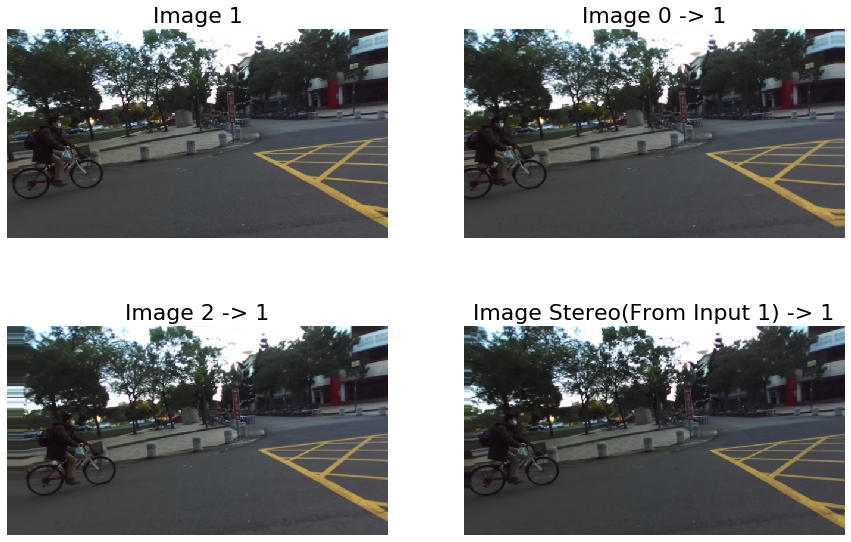

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title("Image 1", fontsize=22)
plt.imshow(input_image_1_pytorch.cpu().numpy()[0].transpose(1, 2, 0))
plt.axis('off')
#plt.show()

plt.subplot(222)
plt.title("Image 0 -> 1", fontsize=22)
plt.imshow(image_warped_0_to_1.cpu().numpy()[0].transpose(1, 2, 0))
plt.axis('off')
#plt.show()

plt.subplot(223)
plt.title("Image 2 -> 1", fontsize=22)
plt.imshow(image_warped_2_to_1.cpu().numpy()[0].transpose(1, 2, 0))
plt.axis('off')
#plt.show()

plt.subplot(224)
plt.title("Image Stereo(From Input 1) -> 1", fontsize=22)
plt.imshow(image_warped_s_to_1.cpu().numpy()[0].transpose(1, 2, 0))
plt.axis('off')
plt.show()